In [40]:
%matplotlib inline

In [41]:
# This notebook reads streamflow measurements and meteorological data
# and exports a dataframe with water balance statistics and streamflow indices.
# Winter streamflow data is missing for some years. Only years with >90% temporal data coverage are considered.
# Gauges with less than 3 years of valid data are omitted.

In [42]:
import sys
sys.path.append(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\code\HydroAnalysis')
import hydroanalysis
from pathlib import Path
import pickle
import pandas as pds
import numpy as np
import geopandas as gpds
import datetime as dt
import matplotlib.pyplot as plt
pds.set_option('display.max_rows', 500)
from pathlib import Path

# Define a function to read csv files containing ERA5-Land data
def read_era_csv(path,start,end):
    var = pds.read_csv(path)
    var = var.set_index('YYYY MM DD')
    var.index = pds.to_datetime(var.index)
    var = var[start:end]
    return(var)

# Read meteorological data and measured streamflow

In [43]:
# Read precip, evap and PET from ERA5-Land
start = '1981-10-01'
end = '2021-09-30'
path_precip = Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\era5_land\1950-2021\daily\ERA5L_total_precipitation.csv')
path_total_evap = Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\era5_land\1950-2021\daily\ERA5L_total_evaporation.csv')
path_potential_evap = Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\era5_land\1950-2021\daily\ERA5L_potential_evaporation.csv')

precip = read_era_csv(path_precip,start,end)
evap = read_era_csv(path_total_evap,start,end)
pet = read_era_csv(path_potential_evap,start,end)

# Read precip from RAV-II
rav_data = pds.read_csv(Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\rav2\rav2_precip_daily_Basins_A.csv")) #header=TRUE,
rav_data.index=pds.to_datetime(rav_data['Time'])
rav_data = rav_data.drop(columns=['Time'])

# Read precip data from CARRA:
#C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\carra\precip_daily
combined_carra = pds.read_csv(Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\carra\precip_daily\carra_precip_daily_Basins_A.csv")) #header=TRUE,
combined_carra.index=pds.to_datetime(combined_carra['time'])
combined_carra = combined_carra.drop(columns=['time'])
# carra_start='1991-10-01'
# carra_end = '2022-09-30'
# carra_dict = dict()
# for wshed in rav_data.columns:
#     path = Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\carra\precip_daily\ID_%s.csv' % wshed)
#     df = pds.read_csv(path)
#     df = df.set_index('time')
#     df.index = pds.to_datetime(df.index)
#     df = df[carra_start:carra_end]
#     carra_dict[wshed] = df
    
# combined_carra = pds.concat(carra_dict, axis=1)
# combined_carra.columns = rav_data.columns
# # combined_carra.round(3).to_csv(Path("C:/Users/hordurbhe/Documents/Vinna/lamah/lamah_ice/era5_land/ts_dec1/daily/carra_total_precipitation.csv"))

# Read gauges shapefile
#gauges = gpds.read_file(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\before_updating_blanda\gauges.shp')
gauges = gpds.read_file(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\GIS\watersheds\final_watersheds\gauges_with_splitted_included.shp')
gauges.index = gauges['id'].astype(int)
gauges.index.name = 'id'

# Read the combined watersheds file with all available attributes
wsheds_attrs = gpds.read_file(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\GIS\watersheds\final_watersheds\final_watersheds/basins_A.shp')
wsheds_attrs.index = wsheds_attrs['id']
wsheds_attrs = wsheds_attrs.drop(columns=['id'])
wsheds_attrs['lat'] = gauges.geometry.y
wsheds_attrs['lon'] = gauges.geometry.x

# Export the ERA5-Land, RAV and CARRA precipitation from Oct. 1. 1991 to August 31. 2019
# start = '1991-10-01'
# end = '2019-08-31'
# concatted_p = pds.concat([precip.mean(),rav_data.mean(),combined_carra.mean()],axis=1)
# concatted_p.columns=['era5_land','rav_ii','carra']
# concatted_p.to_csv(Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\precip_from_era5land_rav_carra.csv"))

# Read the measured streamflow:
save_date = 'july20'
savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\discharge_measurements\processed_by_hh\combined_gauges_LV_VI_raw_%s.p" % save_date)
combined_dict_npc_met_office = pickle.load(open( savepath, "rb" ) )
savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\discharge_measurements\processed_by_hh\combined_gauges_LV_VI_raw_splitted_%s.p" % save_date)
splitted_gauge_dict = pickle.load(open( savepath, "rb" ) )
savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\discharge_measurements\processed_by_hh\combined_gauges_LV_VI_highqual_%s.p" % save_date)
combined_dict_high_qual = pickle.load(open( savepath, "rb" ) )
savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\discharge_measurements\processed_by_hh\combined_gauges_LV_VI_highqual_splitted_%s.p" % save_date)
splitted_gauge_dict_high_qual = pickle.load(open( savepath, "rb" ) )

# Gauges to skip in streamflow indices and water balance plots
gauges_to_skip = ['V404','V328','V183','V112_2','V100_1','V100_3','V68_1']

# Export a water balance .csv file and calculate signatures

In [24]:
# We consider two versions of the streamflow observations: Unfiltered data (all measurements) and filtered data.

# Filtered observations

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quality'][df['Quality']<=100]=0
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quality'][df['Quality']>100]=1
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quality'][df['Qual

Only 0 valid years for V100


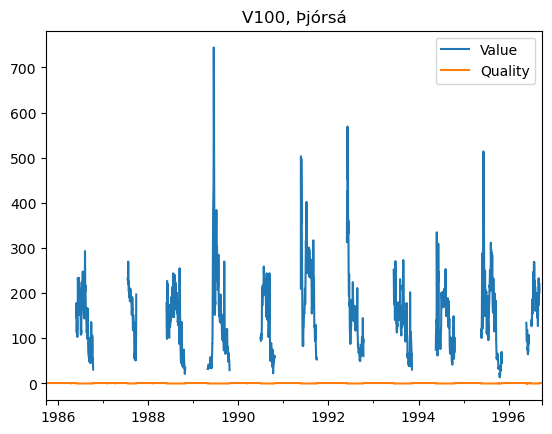

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 0 valid years for V597


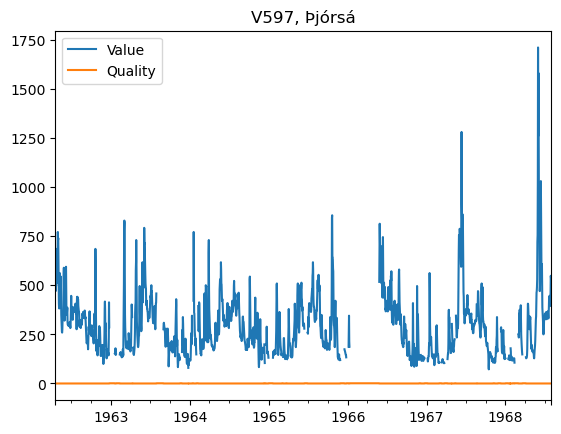

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 1 valid years for 15674


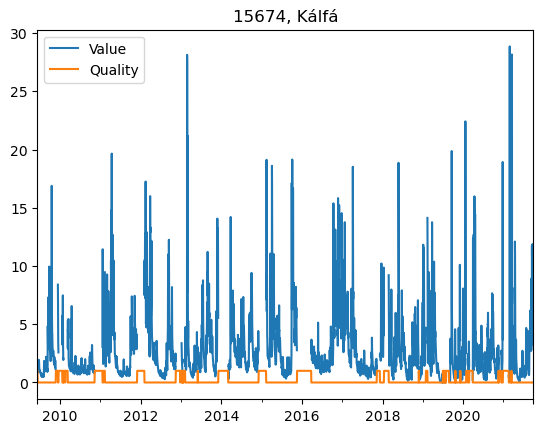

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 0 valid years for 154259


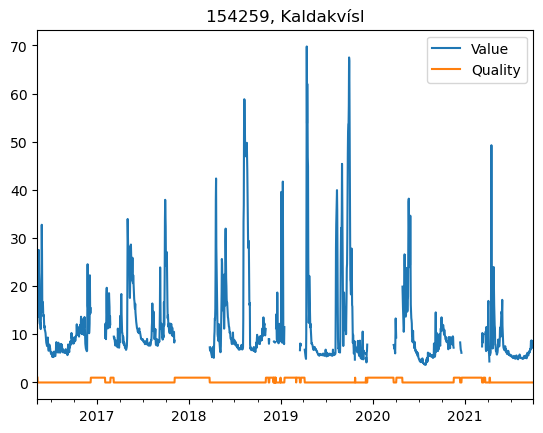

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 0 valid years for V366


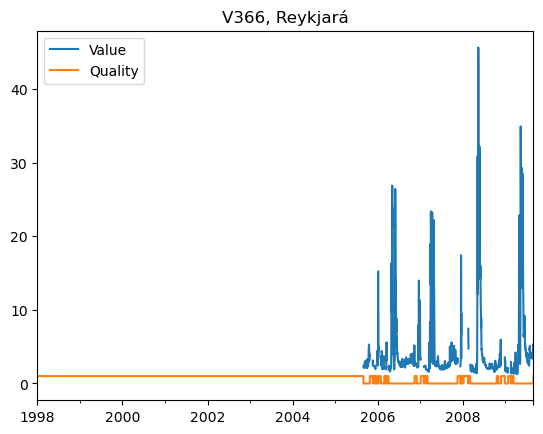

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna


Only 0 valid years for V288


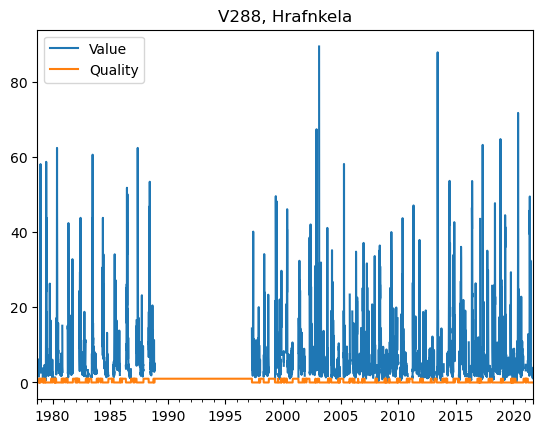

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 0 valid years for V236


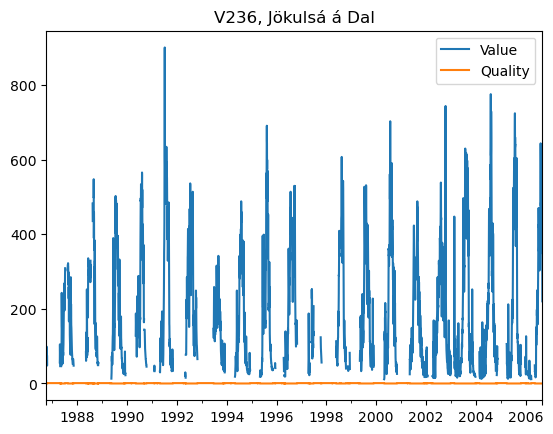

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday


Only 1 valid years for V454


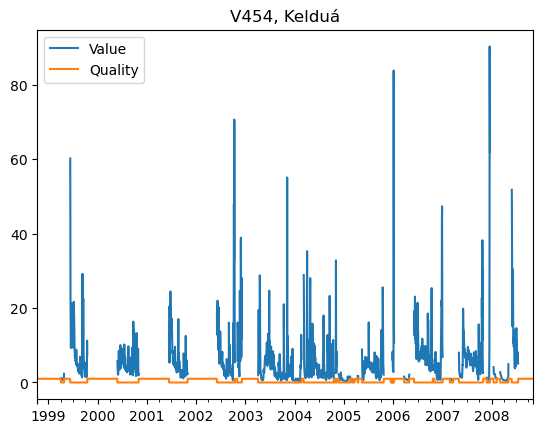

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 2 valid years for V452


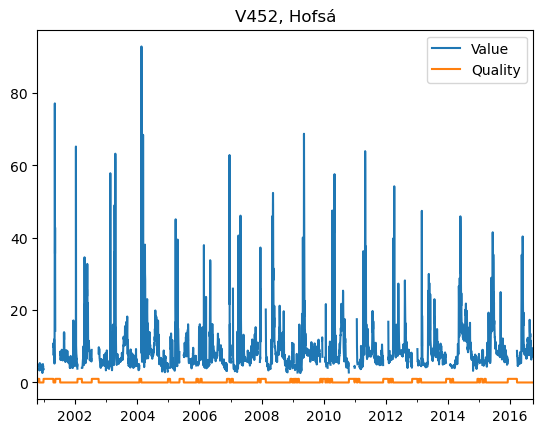

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday


Only 0 valid years for 14418


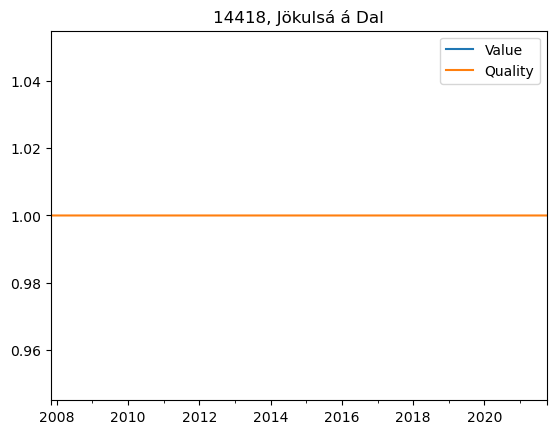

Only 0 valid years for 14393


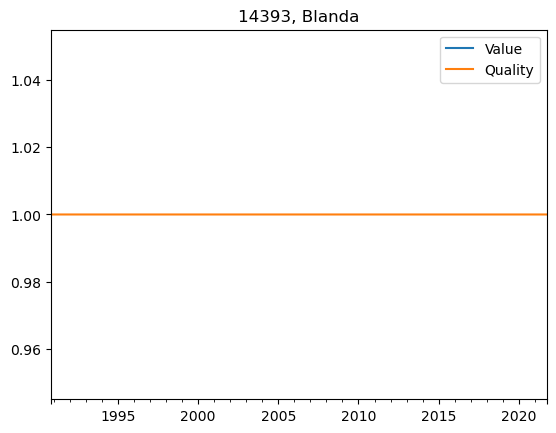

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 0 valid years for V110


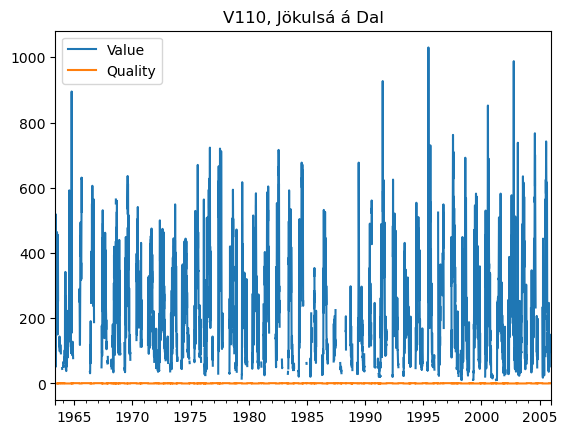

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 1 valid years for V167


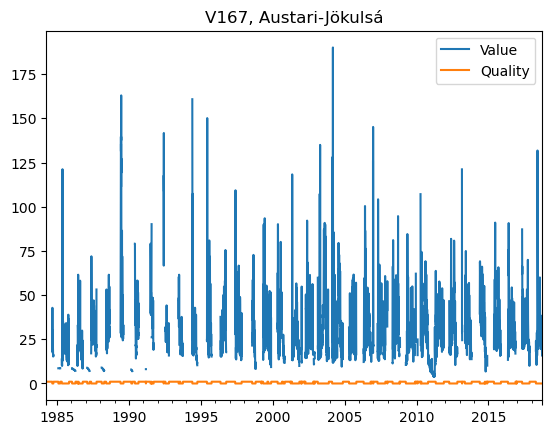

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday


Only 1 valid years for V228


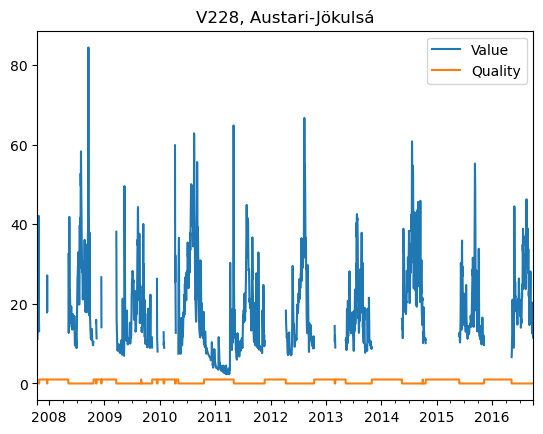

Only 0 valid years for 201035


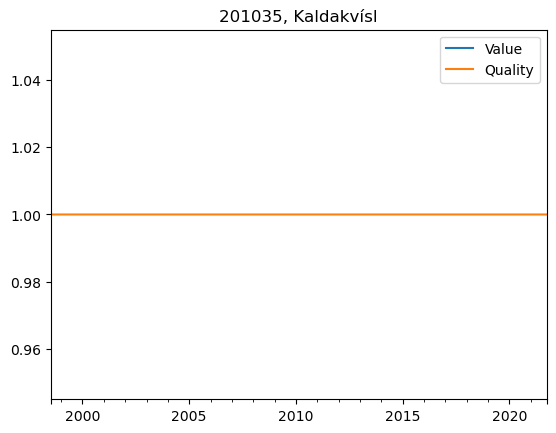

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 2 valid years for 148176


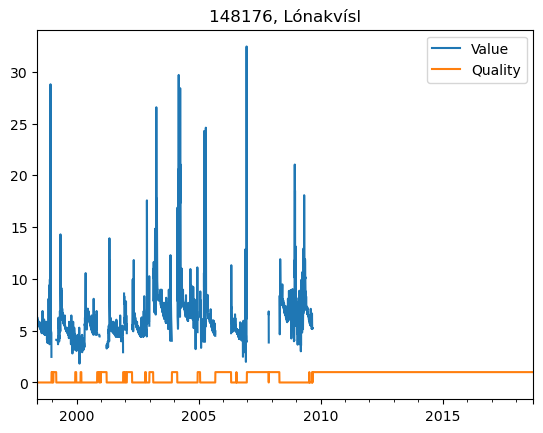

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna


Only 0 valid years for 15653


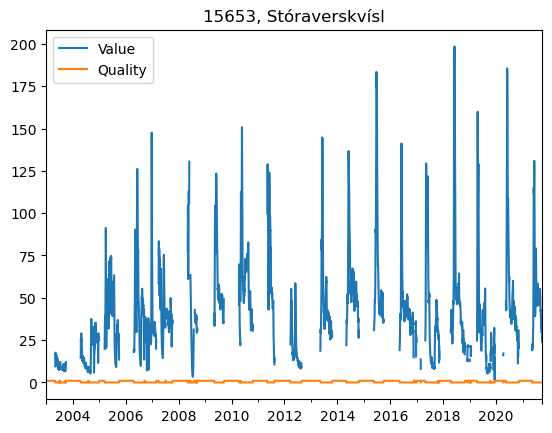

Only 0 valid years for V515


C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna


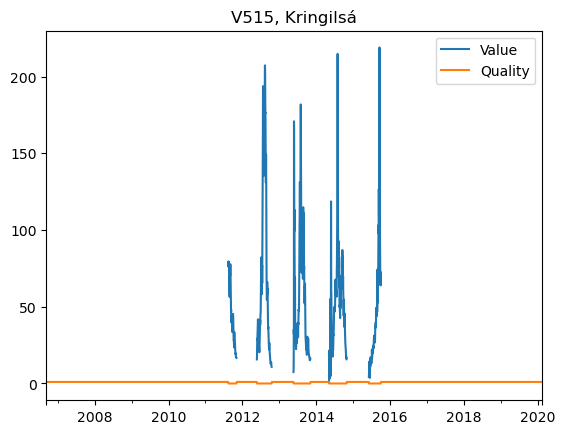

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 0 valid years for V299


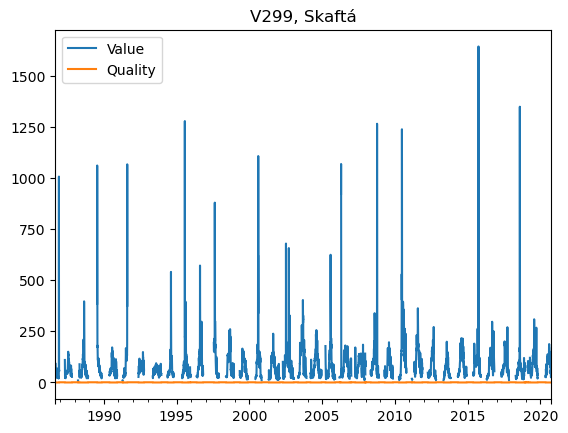

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 0 valid years for V34


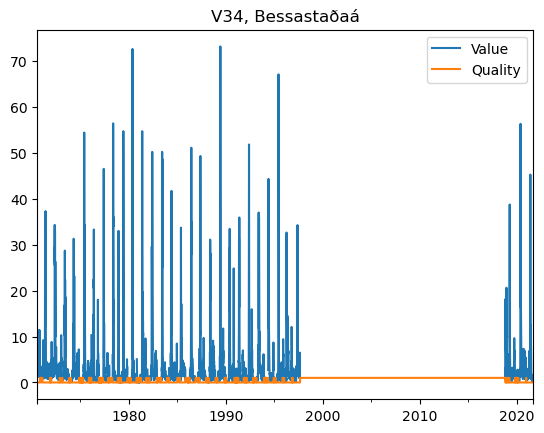

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 1 valid years for V51


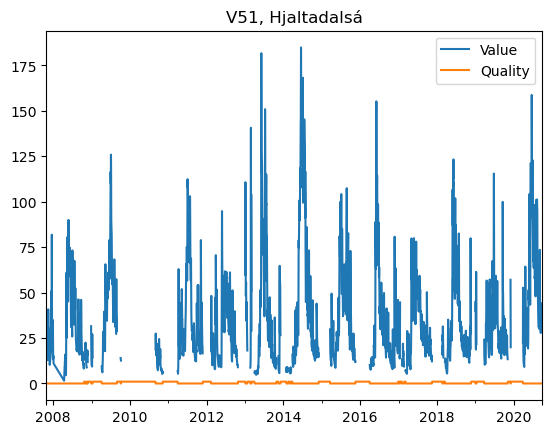

Only 1 valid years for V517


C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday


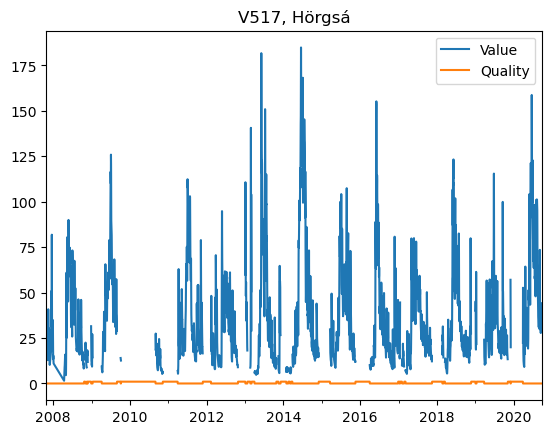

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 0 valid years for V233


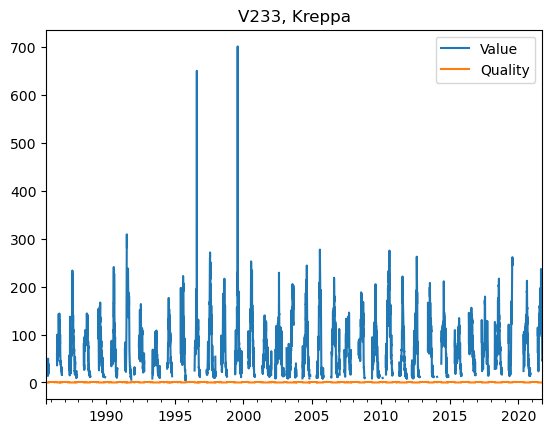

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 1 valid years for V48


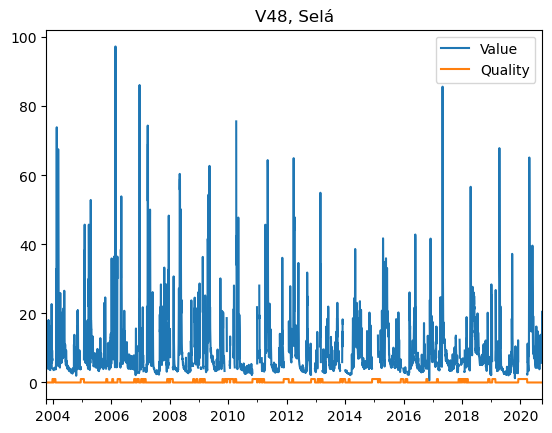

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday


Only 1 valid years for V486


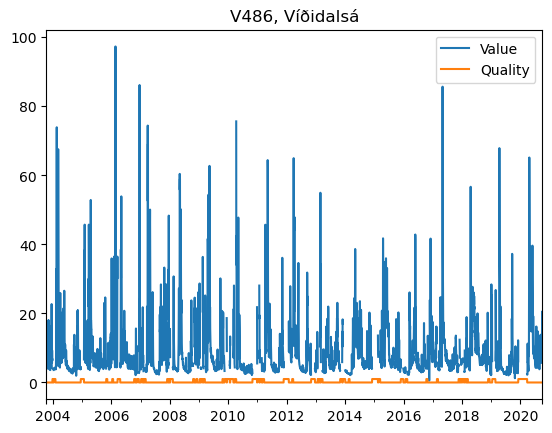

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 0 valid years for V125


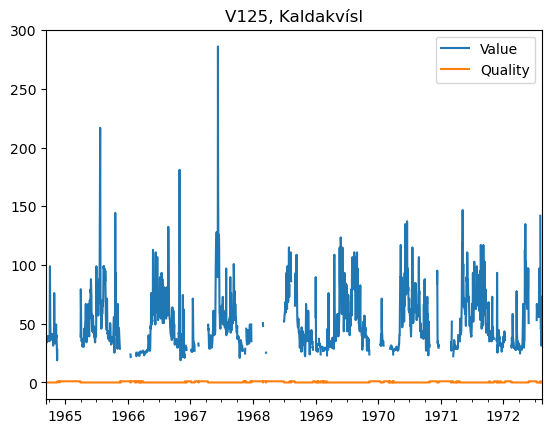

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday


Only 1 valid years for V249


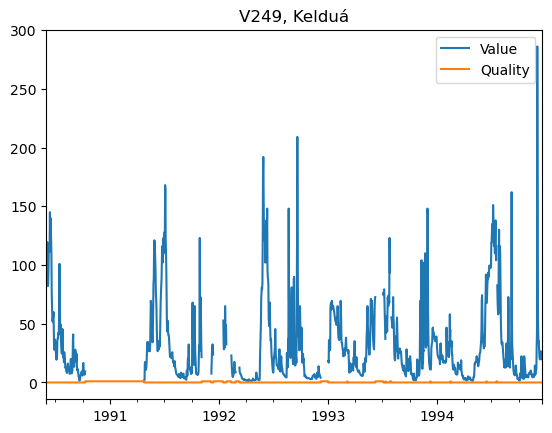

Only 0 valid years for V94


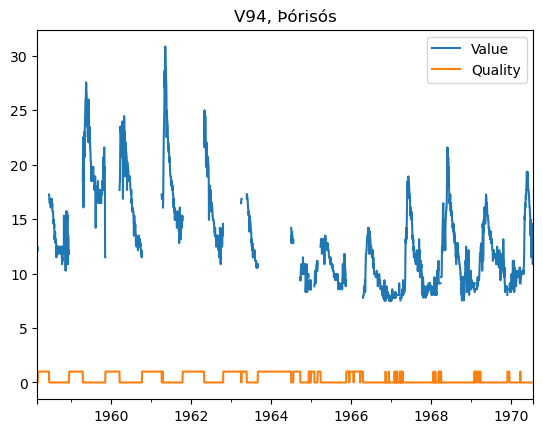

Only 0 valid years for V95


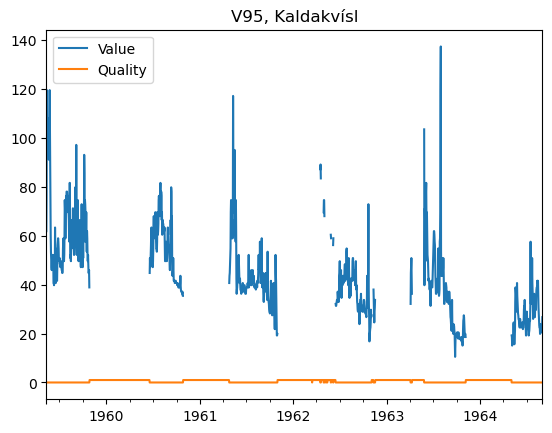

Only 0 valid years for V98


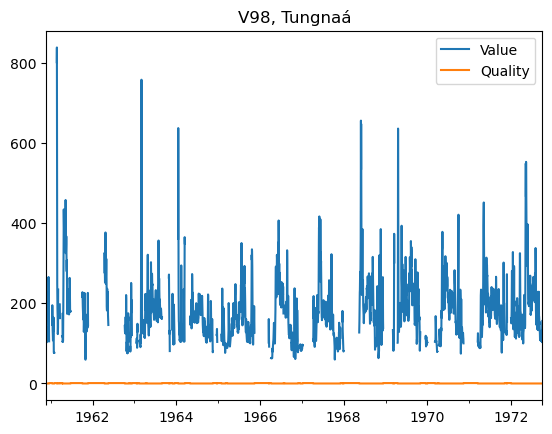

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna


Only 0 valid years for V280


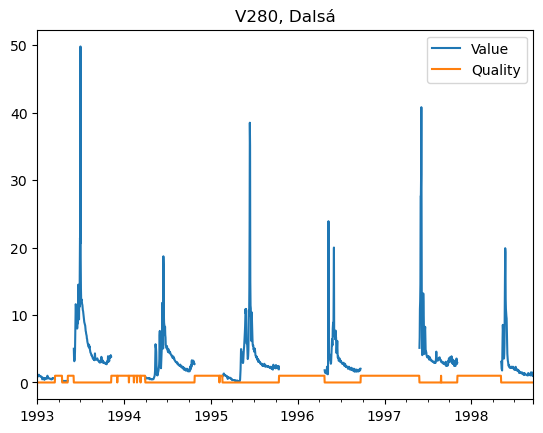

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna


Only 0 valid years for V99


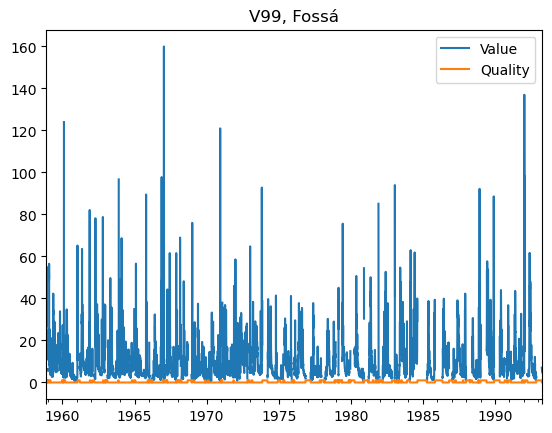

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna


Only 0 valid years for V252


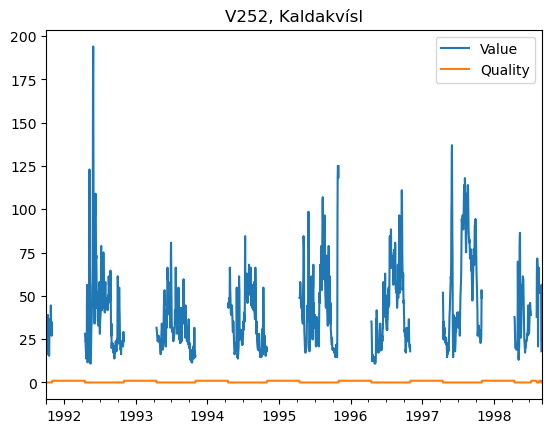

Only 0 valid years for V132


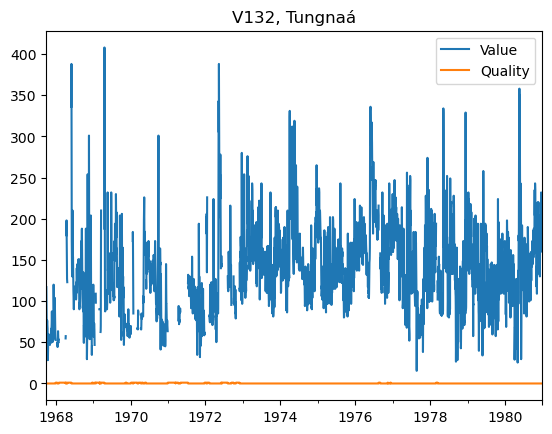

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Only 0 valid years for V198


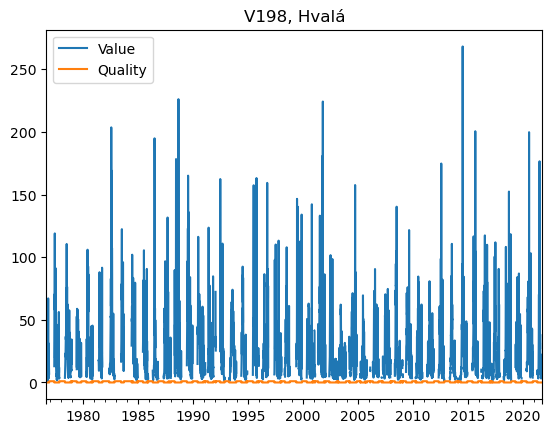

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\133444338.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday


Only 1 valid years for V618


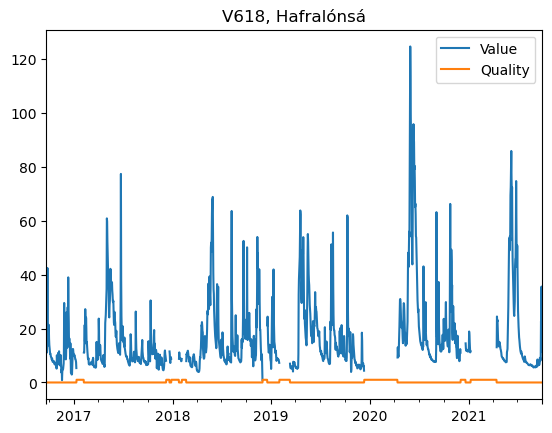

Mean valid years: year_count    15.695652
dtype: float64


In [44]:
# Create a dictionary with measurements that are ready for processing by the hydroanalysis package:
meas_dict = dict()
for gauge in splitted_gauge_dict.keys():
    if gauge in gauges_to_skip: #
        continue
    df = splitted_gauge_dict_high_qual[gauge].copy()
    df.columns=['Value','Quality']
    
    df['Quality'][df['Quality']<=100]=0
    df['Quality'][df['Quality']>100]=1
    # Rename the splitted gauge names (V112_1, V100_1) to their proper gauge names (V112,V100)
    if gauge=='V112_1':
        gauge='V112'
    elif gauge=='V100_2':
        gauge='V100'
    elif gauge=='V68_2':
        gauge='V68'
    meas_dict[gauge] = df

# Create a dictionary that contains a dataframe for each gauge
# The dataframe has the columns: 
# Streamflow meas, quality code, precip from ERA5-Land and RAV-II, PET, total evaporation from ERA5-Land and water year
# If we have less than 3 years of valid data, we don't include the gauge

data_for_valid_years = dict()

# This dictionary keeps track of how many valid years we have for each gauge
valid_years_lengths = dict()

thresh = 0.9

for gauge in meas_dict.keys():
    # Fetch the gauge ID from the station name
    gauge_id = wsheds_attrs.loc[gauges[gauges['st_numer']==gauge].index].index.values[0]    

    # Load the discharge values
    df = meas_dict[gauge].copy()

    try:
        df.index= df.index.date
    except:
        print('df index is already on date format for %s' %gauge)

    # Load ERA precip
    wshed_precip = precip[str(gauge_id)]
    precip_df = pds.DataFrame(wshed_precip)
    precip_df.columns=['P']
    df['P'] = precip_df
    
    # Load PET
    wshed_pet = pet[str(gauge_id)]
    pet_df = pds.DataFrame(wshed_pet)
    pet_df.columns=['PET']
    df['PET'] = pet_df
    
    # Load total evaporation
    wshed_evap = evap[str(gauge_id)]
    et_df = pds.DataFrame(wshed_evap)
    et_df.columns=['ET']
    df['ET'] = et_df
    
    # Load precip from RÁV-II
    rav_precip = rav_data[str(gauge_id)]
    rav_precip_df = pds.DataFrame(rav_precip)
    rav_precip_df.columns=['P_rav']
    df['P_rav'] = rav_precip_df

    # Add column 'water_year'
    water_years = [(d - dt.timedelta(days=273)).year for d in df.index]
    df['water_year'] = water_years

    # Find the index of years where we have data coverage over the threshhold value (90%)
    meas_dropna = df.dropna()
    water_years_dropna = [(d - dt.timedelta(days=273)).year for d in meas_dropna.index]
    meas_dropna['water_year'] = water_years_dropna
    coverage_water_years = meas_dropna['Value'].groupby(water_years_dropna).count()/365

    valid = coverage_water_years.loc[coverage_water_years>=thresh]
    yearcount = len(valid)

    # Get all data for the water years that are valid
    df_valid = df[df['water_year'].isin(valid.index)]

    # Convert streamflow measurements from daily mean m3/s to mm/d
    streamflow_values = df_valid['Value'].values
    streamflow_values_mmday = 1000*(streamflow_values*86400/(wsheds_attrs.loc[gauges[gauges['st_numer']==gauge].index]['area_calc'].values[0]*1000000))

    df_valid['Value mm'] = streamflow_values_mmday

    if yearcount>=3:
        data_for_valid_years[gauge] = df_valid[['Value mm','Quality','P','PET','ET','water_year','P_rav']]
    else:
        print('Only %s valid years for %s' % (yearcount,gauge))
        meas_dict[gauge].plot()
        plt.title('%s, %s' %(gauge,gauges[gauges['st_numer']==gauge]['vatnsfall'].values[0]))
        plt.show()
    valid_years_lengths[gauge_id] = {'year_count': yearcount}
    
valid_years_df = pds.DataFrame(valid_years_lengths)
valid_years_df = valid_years_df.reindex(sorted(valid_years_df.columns), axis=1)
valid_years_df = valid_years_df.T

# Save wbalance df
w_balance_dict = dict()
for gauge in data_for_valid_years.keys():
    # Fetch the gauge ID from the station name
    gauge_id = wsheds_attrs.loc[gauges[gauges['st_numer']==gauge].index].index.values[0]
    
    # Create a dataframe with the measured discharge, quality value, precipitation and water year
    df = data_for_valid_years[gauge]
    
    # Calculate means
    w_balance_dict[gauge_id] = df.mean()
    
wb_df = pds.DataFrame(w_balance_dict)
wb_df = wb_df.reindex(sorted(wb_df.columns), axis=1)
final_wb_df = wb_df.T

# Save water balance dataframe as .csv
folder = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes")
path = folder/'water_balance.csv'
final_wb_df.to_csv(path)

# Now the hydrological signatures calculations:
signs_dict = dict()
for gauge in data_for_valid_years.keys():
    # Fetch the gauge ID from the station name
    gauge_id = wsheds_attrs.loc[gauges[gauges['st_numer']==gauge].index].index.values[0]
    
    # Create a dataframe with the measured discharge, quality value, precipitation and water year
    df = data_for_valid_years[gauge]
    
    # Calculate signatures
    try:
        signs_dict[gauge_id] = hydroanalysis.utils.calculate_multiple_signatures([hydroanalysis.streamflow_signatures.calculate_q_mean,
                                                       hydroanalysis.streamflow_signatures.calculate_runoff_ratio,
                                                       hydroanalysis.streamflow_signatures.calculate_stream_elas,
                                                       hydroanalysis.streamflow_signatures.calculate_slope_fdc,
                                                       hydroanalysis.streamflow_signatures.calculate_baseflow_index,
                                                       hydroanalysis.streamflow_signatures.calculate_hfd_mean,
                                                       hydroanalysis.streamflow_signatures.calculate_q_5,
                                                       hydroanalysis.streamflow_signatures.calculate_q_95,
                                                       hydroanalysis.streamflow_signatures.calculate_high_q_freq_dur,
                                                       hydroanalysis.streamflow_signatures.calculate_low_q_freq_dur,
                                                       hydroanalysis.streamflow_signatures.calculate_zero_q_freq],
                                                      df['Value mm'].values, #streamflow_values_mmday,
                                                      df['Quality'].values,
                                                      df['P'].values,
                                                      df['water_year'].values) #np.array(water_years))
    except TypeError:
        print('Wrong output type for %s' % gauge) 

signs_df = pds.DataFrame(signs_dict)
signs_df = signs_df.reindex(sorted(signs_df.columns), axis=1)
final_df = signs_df.T

# Rename the columns 
final_df = final_df[['calculate_q_mean', 'calculate_runoff_ratio',
       'calculate_stream_elas_Sankarasubramanian',
       'calculate_slope_fdc_Addor',
       'calculate_baseflow_index', 'calculate_hfd_mean_hfd_mean',
       'calculate_q_5', 'calculate_q_95',
       'calculate_high_q_freq_dur_hq_freq', 'calculate_high_q_freq_dur_hq_dur',
       'calculate_low_q_freq_dur_lq_freq', 'calculate_low_q_freq_dur_lq_dur',
       'calculate_zero_q_freq']]
new_column_names = ['q_mean','runoff_ratio','stream_elas',
                    'slope_fdc','baseflow_index_ladson',
                    'hfd_mean','Q5',
                    'Q95','high_q_freq','high_q_dur','low_q_freq',
                    'low_q_dur','zero_q_freq']
final_df.columns=new_column_names

path = folder/'valid_years_10_perc_tol_1981_2021.csv'
valid_years_df.to_csv(path)

path = folder/'hydro_sign_10_perc_tol_only_more_than_2_years_1981_2021.csv'
final_df.to_csv(path)
print('Mean valid years: %s' %valid_years_df[valid_years_df>2].mean())

In [52]:
len(valid_years_df[valid_years_df>2].dropna())

69

In [47]:
len(final_df)

69

# Unfiltered observations:

In [39]:
wsheds_attrs.loc[gauges[gauges['st_numer']=='V112'].index].index.values[0]

1010

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quality'][df['Quality']<=200]=0
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quality'][df['Quality']>200]=1
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quality'][df[

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna


Only 0 valid years for V100


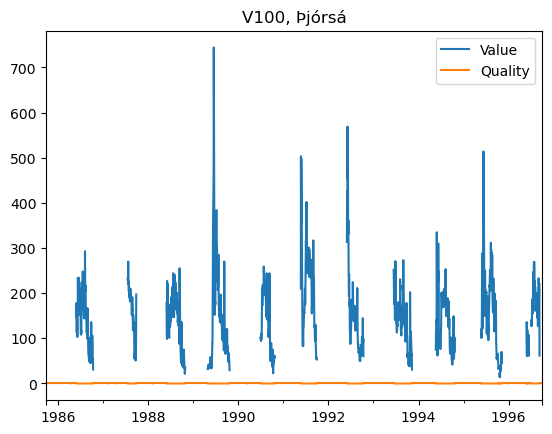

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Only 0 valid years for V597


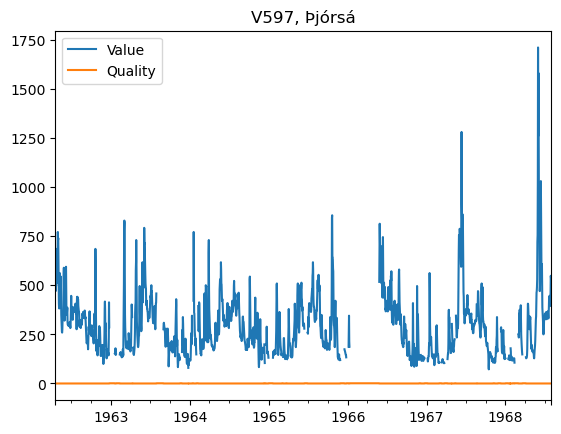

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Only 2 valid years for V515


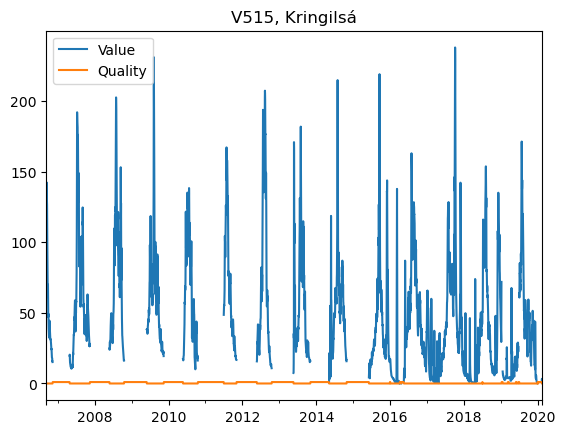

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Only 0 valid years for V125


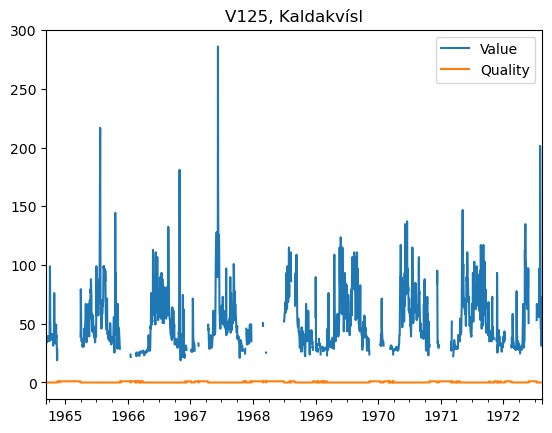

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday


Only 0 valid years for V94


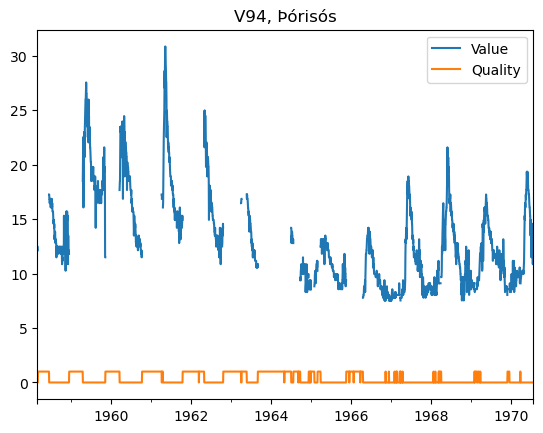

Only 0 valid years for V95


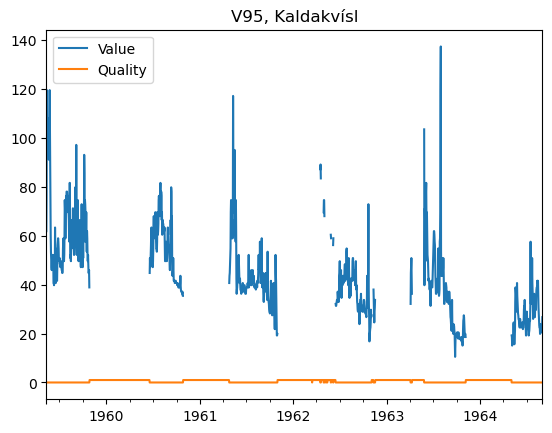

Only 0 valid years for V98


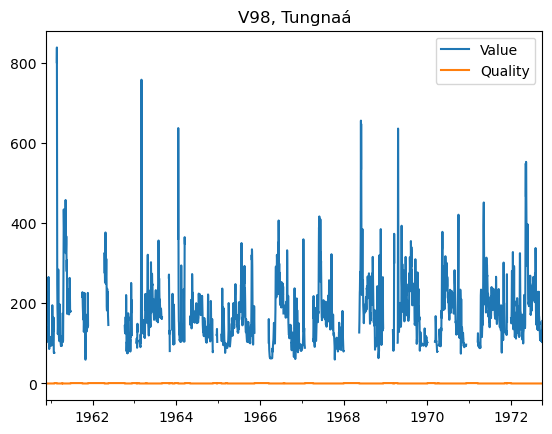

Only 2 valid years for V280


C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday


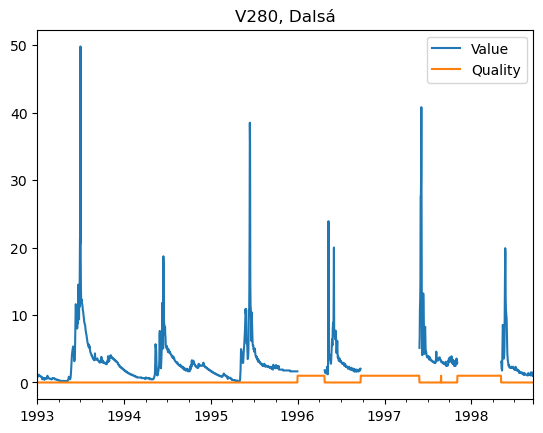

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna


Only 0 valid years for V99


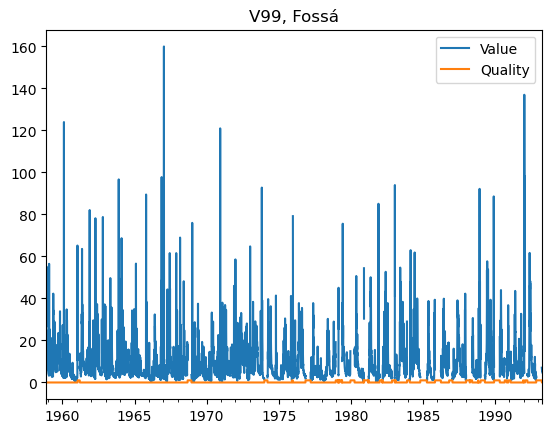

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna


Only 0 valid years for V252


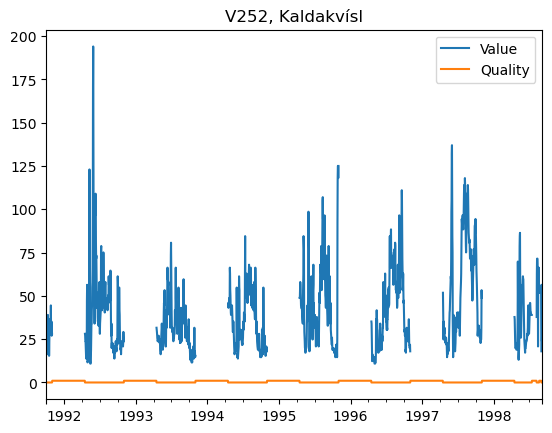

Only 0 valid years for V132


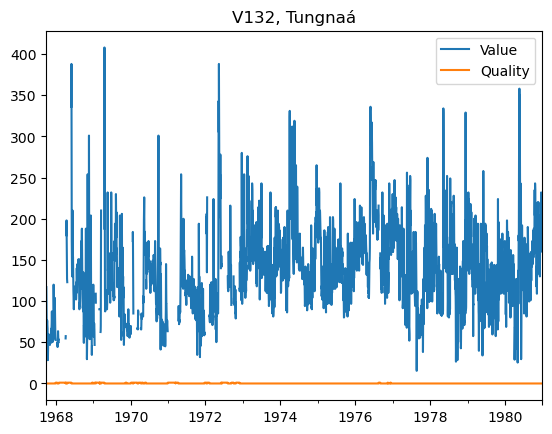

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Value mm'] = streamflow_values_mmday
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meas_dropna['water_year'] = water_years_dropna
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_7992\2124052016.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [37]:
# Same code as above. We now use the splitted_gauge_dict that includes all streamflow measurements (unfiltered version) 
gauges_to_skip = ['V404','V328','V183','V112_2','V100_1','V100_3','V68_1']

meas_dict = dict()
for gauge in splitted_gauge_dict.keys():
    if gauge in gauges_to_skip: #
        continue
    df = splitted_gauge_dict[gauge].copy()
    df.columns=['Value','Quality']
    
    df['Quality'][df['Quality']<=200]=0
    df['Quality'][df['Quality']>200]=1
    # Rename the splitted gauge names (V112_1, V100_1) to their proper gauge names (V112,V100)
    if gauge=='V112_1':
        gauge='V112'
    elif gauge=='V100_2':
        gauge='V100'
    elif gauge=='V68_2':
        gauge='V68'
    meas_dict[gauge] = df
    
# Create a dictionary that contains a dataframe for each gauge
# The dataframe has the columns: 
# Streamflow meas, quality code, precip from ERA5-Land and RAV-II, PET, total evaporation from ERA5-Land and water year
# If we have less than 3 years of valid data, we don't include the gauge

data_for_valid_years = dict()

# This dictionary keeps track of how many valid years we have for each gauge
valid_years_lengths = dict()

thresh = 0.9

for gauge in meas_dict.keys():
    # Fetch the gauge ID from the station name
    gauge_id = wsheds_attrs.loc[gauges[gauges['st_numer']==gauge].index].index.values[0]    

    # Load the discharge values
    df = meas_dict[gauge].copy()

    try:
        df.index= df.index.date
    except:
        print('df index is already on date format for %s' %gauge)

    # Load ERA precip
    wshed_precip = precip[str(gauge_id)]
    precip_df = pds.DataFrame(wshed_precip)
    precip_df.columns=['P']
    df['P'] = precip_df
    
    # Load PET
    wshed_pet = pet[str(gauge_id)]
    pet_df = pds.DataFrame(wshed_pet)
    pet_df.columns=['PET']
    df['PET'] = pet_df
    
    # Load total evaporation
    wshed_evap = evap[str(gauge_id)]
    et_df = pds.DataFrame(wshed_evap)
    et_df.columns=['ET']
    df['ET'] = et_df
    
    # Load precip from RÁV-II
    rav_precip = rav_data[str(gauge_id)]
    rav_precip_df = pds.DataFrame(rav_precip)
    rav_precip_df.columns=['P_rav']
    df['P_rav'] = rav_precip_df

    # Add column 'water_year'
    water_years = [(d - dt.timedelta(days=273)).year for d in df.index]
    df['water_year'] = water_years

    # Find the index of years where we have data coverage over the threshhold value (90%)
    meas_dropna = df.dropna()
    water_years_dropna = [(d - dt.timedelta(days=273)).year for d in meas_dropna.index]
    meas_dropna['water_year'] = water_years_dropna
    coverage_water_years = meas_dropna['Value'].groupby(water_years_dropna).count()/365

    valid = coverage_water_years.loc[coverage_water_years>=thresh]
    yearcount = len(valid)

    # Get all data for the water years that are valid
    df_valid = df[df['water_year'].isin(valid.index)]

    # Convert streamflow measurements from daily mean m3/s to mm/d
    streamflow_values = df_valid['Value'].values
    streamflow_values_mmday = 1000*(streamflow_values*86400/(wsheds_attrs.loc[gauges[gauges['st_numer']==gauge].index]['area_calc'].values[0]*1000000))

    df_valid['Value mm'] = streamflow_values_mmday

    if yearcount>=3:
        data_for_valid_years[gauge] = df_valid[['Value mm','Quality','P','PET','ET','water_year','P_rav']]
    else:
        print('Only %s valid years for %s' % (yearcount,gauge))
        meas_dict[gauge].plot()
        plt.title('%s, %s' %(gauge,gauges[gauges['st_numer']==gauge]['vatnsfall'].values[0]))
        plt.show()
    valid_years_lengths[gauge_id] = {'year_count': yearcount}
    
valid_years_df = pds.DataFrame(valid_years_lengths)
valid_years_df = valid_years_df.reindex(sorted(valid_years_df.columns), axis=1)
valid_years_df = valid_years_df.T

# Save wbalance df
w_balance_dict = dict()
for gauge in data_for_valid_years.keys():
    # Fetch the gauge ID from the station name
    gauge_id = wsheds_attrs.loc[gauges[gauges['st_numer']==gauge].index].index.values[0]
    
    # Create a dataframe with the measured discharge, quality value, precipitation and water year
    df = data_for_valid_years[gauge]
    
    # Calculate means
    w_balance_dict[gauge_id] = df.mean()
    
wb_df = pds.DataFrame(w_balance_dict)
wb_df = wb_df.reindex(sorted(wb_df.columns), axis=1)
final_wb_df = wb_df.T

folder = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes")
path = folder/'water_balance_unfiltered_including_unchecked.csv'

# Save water balance dataframe as .csv
# path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\water_balance_unfiltered_including_unchecked.csv")
final_wb_df.to_csv(path)

# Now the hydrological signatures calculations:
signs_dict = dict()
for gauge in data_for_valid_years.keys():
    # Fetch the gauge ID from the station name
    gauge_id = wsheds_attrs.loc[gauges[gauges['st_numer']==gauge].index].index.values[0]
    
    # Create a dataframe with the measured discharge, quality value, precipitation and water year
    df = data_for_valid_years[gauge]
    
    # Calculate signatures
    try:
        signs_dict[gauge_id] = hydroanalysis.utils.calculate_multiple_signatures([hydroanalysis.streamflow_signatures.calculate_q_mean,
                                                       hydroanalysis.streamflow_signatures.calculate_runoff_ratio,
                                                       hydroanalysis.streamflow_signatures.calculate_stream_elas,
                                                       hydroanalysis.streamflow_signatures.calculate_slope_fdc,
                                                       hydroanalysis.streamflow_signatures.calculate_baseflow_index,
                                                       hydroanalysis.streamflow_signatures.calculate_hfd_mean,
                                                       hydroanalysis.streamflow_signatures.calculate_q_5,
                                                       hydroanalysis.streamflow_signatures.calculate_q_95,
                                                       hydroanalysis.streamflow_signatures.calculate_high_q_freq_dur,
                                                       hydroanalysis.streamflow_signatures.calculate_low_q_freq_dur,
                                                       hydroanalysis.streamflow_signatures.calculate_zero_q_freq],
                                                      df['Value mm'].values, #streamflow_values_mmday,
                                                      df['Quality'].values,
                                                      df['P'].values,
                                                      df['water_year'].values) #np.array(water_years))
    except TypeError:
        print(hallo)
        print('Wrong output type for %s' % gauge) 

signs_df = pds.DataFrame(signs_dict)
signs_df = signs_df.reindex(sorted(signs_df.columns), axis=1)
final_df = signs_df.T

# Rename the columns 
final_df = final_df[['calculate_q_mean', 'calculate_runoff_ratio',
       'calculate_stream_elas_Sankarasubramanian',
       'calculate_slope_fdc_Addor',
       'calculate_baseflow_index', 'calculate_hfd_mean_hfd_mean',
       'calculate_q_5', 'calculate_q_95',
       'calculate_high_q_freq_dur_hq_freq', 'calculate_high_q_freq_dur_hq_dur',
       'calculate_low_q_freq_dur_lq_freq', 'calculate_low_q_freq_dur_lq_dur',
       'calculate_zero_q_freq']]
new_column_names = ['q_mean','runoff_ratio','stream_elas',
                    'slope_fdc','baseflow_index_ladson',
                    'hfd_mean','Q5',
                    'Q95','high_q_freq','high_q_dur','low_q_freq',
                    'low_q_dur','zero_q_freq']
final_df.columns=new_column_names

path = folder/'valid_years_10_perc_tol_1981_2021_unfiltered_including_unchecked.csv'
# path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\valid_years_10_perc_tol_1981_2021_unfiltered_including_unchecked.csv")
valid_years_df.to_csv(path)

path = folder/'hydro_sign_10_perc_tol_only_more_than_2_years_1981_2021_unfiltered_including_unchecked.csv'
# path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\hydro_sign_10_perc_tol_only_more_than_2_years_1981_2021_unfiltered_including_unchecked.csv")
final_df.to_csv(path)
# valid_years_df[valid_years_df>2].mean()